In [1]:
# --- INSTALLING LIBRARIES ---
!pip install --upgrade transformers accelerate datasets scikit-learn -q

# --- IMPORTING LIBRARIES ---
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoTokenizer, RobertaModel, TrainingArguments, Trainer # CHANGE 1 & 2: Replaced DistilBertModel with RobertaModel
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight 
import matplotlib.pyplot as plt
import seaborn as sns
import os

RNG = 42

# --- LOADING THE DATASET ---

# ✅ FIXED PATH BELOW
FILE_PATH = '/kaggle/input/composite-1-194k-data/Composite1_194kdata.csv' 

print(f"Loading dataset from: {FILE_PATH}")

try:
    df = pd.read_csv(FILE_PATH)
except FileNotFoundError:
    print("\n❌ ERROR: File not found!")
    print(f"Please verify the path: {FILE_PATH}")
    print("Tip: In Kaggle, check the 'Input' section on the right sidebar to copy the exact path.")
    raise

# --- SANITY CHECK ---
needed_cols = [
    'title', 'reviewText', 'audienceScore', 'tomatoMeter', 'runtimeMinutes',
    'genre', 'language_encoded', 'director_encoded', 'target_label'
]

missing = [c for c in needed_cols if c not in df.columns]
if missing:
    raise ValueError(f"❌ CRITICAL ERROR: Your CSV is missing these columns: {missing}")

print("--- Part 1: Setup and Data Loading Complete (Kaggle Version) ---")
print(f"Dataset loaded with {df.shape[0]} rows.")
print(f"Target Distribution:\n{df['target_label'].value_counts().sort_index()}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.

2025-11-21 22:03:24.050568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763762604.312092      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763762604.373191      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Loading dataset from: /kaggle/input/composite-1-194k-data/Composite1_194kdata.csv
--- Part 1: Setup and Data Loading Complete (Kaggle Version) ---
Dataset loaded with 194801 rows.
Target Distribution:
target_label
0    55029
1    69605
2    70167
Name: count, dtype: int64


In [2]:
# --- PART 2: PREPROCESSING & FEATURE ENGINEERING ---

import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from packaging import version
import sklearn

# Ensure 'df' and 'RNG' exist from Part 1
if 'df' not in globals():
    raise ValueError("❌ 'df' is missing! Please run Part 1 to load the data first.")

# --- CLEANING ---
print("Cleaning data...")
df = df.dropna(subset=['reviewText', 'target_label']).copy()
# Map 'target_label' to the standard 'label' column expected by HF
df['label'] = df['target_label'].astype(int)

class_names = ['Negative', 'Neutral', 'Positive']
N_CLASSES = 3

# Text Prep
df['title'] = df['title'].fillna("")
df['genre'] = df['genre'].fillna("Unknown")
df['combined_text'] = df['title'] + " [SEP] " + df['reviewText']

# --- STRATIFIED SPLIT ---
print("Splitting data (Stratified)...")
train_idx, test_idx = train_test_split(
    df.index, test_size=0.2, random_state=RNG, stratify=df['label']
)
train_df = df.loc[train_idx].reset_index(drop=True)
test_df  = df.loc[test_idx].reset_index(drop=True)

y_train = train_df['label'].values.astype(int)

# ==========================================
# CRITICAL: CALCULATE CLASS WEIGHTS
# ==========================================
print("Calculating class weights...")
# This forces the model to pay attention to minority classes
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("\n⚖️ Calculated Class Weights (Neg, Neu, Pos):")
print(class_weights)
print("(The model will use these to penalize mistakes on smaller classes more heavily)")

# ==========================================
# FEATURE ENGINEERING (Fit on Train)
# ==========================================
print("Starting Feature Engineering...")

# 1. Numeric
print("-> Processing Numeric features...")
NUMERIC_COLS = ['tomatoMeter', 'audienceScore', 'runtimeMinutes']
train_numeric = train_df[NUMERIC_COLS].copy()
train_medians = train_numeric.median(numeric_only=True)
train_numeric = train_numeric.fillna(train_medians)

scaler = StandardScaler()
scaler.fit(train_numeric.values)

# 2. Categorical: Genre
print("-> Processing Genre...")
train_genre_list = train_df['genre'].fillna("Unknown").str.split(', ')
mlb = MultiLabelBinarizer()
mlb.fit(train_genre_list)

# 3. Categorical: Language
print("-> Processing Language...")
train_lang = train_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')

# Handle sklearn version differences (Kaggle usually has the latest, but this is safe)
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe_lang = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.float32)
else:
    ohe_lang = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=np.float32)

ohe_lang.fit(train_lang.to_frame())

# 4. Categorical: Director (Robust Target Encoding)
print("-> Processing Director (Target Encoding)...")
def director_features_multiclass(train_s, y, test_s, n_splits=5):
    s_train = train_s.fillna("Unknown").astype(str)
    s_test  = test_s.fillna("Unknown").astype(str)

    # Frequency
    freq = s_train.value_counts()
    tr_freq = np.log1p(s_train.map(freq).fillna(0).values)[:, None].astype(np.float32)
    te_freq = np.log1p(s_test.map(freq).fillna(0).values)[:, None].astype(np.float32)

    # K-Fold Target Mean
    n_classes = len(np.unique(y))
    y_ohe = OneHotEncoder(categories=[range(n_classes)], sparse_output=False, dtype=np.float32).fit_transform(y.reshape(-1, 1))
    global_mean = y_ohe.mean(axis=0)

    tr_te = np.zeros((len(s_train), n_classes), dtype=np.float32)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RNG)

    for tr_i, val_i in skf.split(np.zeros(len(y)), y):
        tr_fold = s_train.iloc[tr_i]
        # Compute means
        fold_means = pd.DataFrame(y_ohe[tr_i], index=tr_fold.index).groupby(tr_fold).mean()

        # Map to validation
        val_fold = s_train.iloc[val_i].to_frame(name='did')
        merged = val_fold.merge(fold_means, left_on='did', right_index=True, how='left')
        vals = merged.drop('did', axis=1).values

        # Fill NaN with global mean
        mask = np.isnan(vals.sum(axis=1))
        vals[mask] = global_mean
        tr_te[val_i] = vals.astype(np.float32)

    # Test set mapping (using full train)
    full_means = pd.DataFrame(y_ohe, index=s_train.index).groupby(s_train).mean()
    test_df_map = s_test.to_frame(name='did')
    merged_test = test_df_map.merge(full_means, left_on='did', right_index=True, how='left')
    te_te = merged_test.drop('did', axis=1).values
    mask_test = np.isnan(te_te.sum(axis=1))
    te_te[mask_test] = global_mean

    return tr_freq, te_freq, tr_te, te_te

# Apply Director Encoding
dtr_f, dte_f, dtr_te, dte_te = director_features_multiclass(
    train_df['director_encoded'].astype(str), y_train,
    test_df['director_encoded'].astype(str)
)

dir_train_block = np.concatenate([dtr_f, dtr_te], axis=1).astype(np.float32)
dir_test_block  = np.concatenate([dte_f, dte_te], axis=1).astype(np.float32)

print("--- Part 2: Preprocessing & Weights Complete ---")

Cleaning data...
Splitting data (Stratified)...
Calculating class weights...

⚖️ Calculated Class Weights (Neg, Neu, Pos):
tensor([1.1800, 0.9329, 0.9254])
(The model will use these to penalize mistakes on smaller classes more heavily)
Starting Feature Engineering...
-> Processing Numeric features...
-> Processing Genre...
-> Processing Language...
-> Processing Director (Target Encoding)...
--- Part 2: Preprocessing & Weights Complete ---


In [3]:
# --- PART 3: DATASET CREATION & TOKENIZATION ---

import numpy as np
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

# Ensure prerequisites from Part 2 exist
required_vars = ['train_df', 'test_df', 'dir_train_block', 'dir_test_block', 'scaler', 'mlb', 'ohe_lang', 'train_medians']
if not all(v in globals() for v in required_vars):
    raise ValueError("❌ Missing variables from Part 2. Please run the previous cell first.")

# Define helper function
def build_features(split_df, dir_block):
    out = {}
    out['combined_text'] = split_df['combined_text'].tolist()
    out['label'] = split_df['label'].astype(int).tolist()

    # Numeric
    # NUMERIC_COLS was defined in Part 2
    numeric = split_df[NUMERIC_COLS].copy().fillna(train_medians)
    out['numerical_features'] = scaler.transform(numeric.values).astype(np.float32)

    # Genre
    genre_list = split_df['genre'].fillna("Unknown").str.split(', ')
    
    # Concatenate all categorical features
    out['categorical_features'] = np.concatenate([
        mlb.transform(genre_list),
        ohe_lang.transform(split_df['language_encoded'].astype('Int64').astype(str).fillna('unknown').to_frame()),
        dir_block
    ], axis=1).astype(np.float32)
    
    return out

print("Building features dictionaries...")
train_feats = build_features(train_df, dir_train_block)
test_feats  = build_features(test_df, dir_test_block)

# Dimensions
num_numerical_features = 3
num_categorical_features = train_feats['categorical_features'].shape[1]
print(f"Feature Dims: Numeric={num_numerical_features}, Categorical={num_categorical_features}")

# HF Dataset
print("Converting to Hugging Face Datasets...")
raw_datasets = DatasetDict({
    'train': Dataset.from_dict(train_feats),
    'test':  Dataset.from_dict(test_feats),
})

# Tokenization
# 💥 CHANGE 1: Swapping 'roberta-large' for 'roberta-base'
MODEL_CHECKPOINT = "roberta-base" 

print(f"Downloading Tokenizer ({MODEL_CHECKPOINT})...")
# ⚠️ KAGGLE NOTE: Ensure 'Internet' is enabled in the Settings sidebar!
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
except Exception as e:
    print("\n❌ ERROR: Could not download tokenizer.")
    print("Please check if 'Internet' is enabled in the Kaggle Notebook settings (Right Sidebar > Settings > Internet 'On').")
    raise e

def tokenize_fn(examples):
    # The max_length=256 remains a good default for RoBERTa.
    return tokenizer(examples["combined_text"], padding="max_length", truncation=True, max_length=256)

print("Tokenizing dataset (this may take a moment)...")
tokenized_datasets = raw_datasets.map(tokenize_fn, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["combined_text"])
tokenized_datasets.set_format("torch")

print("--- Part 3: Dataset Ready & Tokenized ---")

Building features dictionaries...


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['other'] will be ignored
  warnings.warn(


Feature Dims: Numeric=3, Categorical=49
Converting to Hugging Face Datasets...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenizing dataset (this may take a moment)...


Map:   0%|          | 0/155840 [00:00<?, ? examples/s]

Map:   0%|          | 0/38961 [00:00<?, ? examples/s]

--- Part 3: Dataset Ready & Tokenized ---


In [4]:
# --- PART 4: MODEL SETUP & TRAINING (KAGGLE VERSION - FIXED) ---

import torch
import torch.nn as nn
from transformers import Trainer, TrainingArguments, RobertaModel 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import os

# --- SAFETY CHECK ---
if 'class_weights' not in globals():
    raise ValueError("❌ 'class_weights' is missing! Please run Part 2 first.")
if 'MODEL_CHECKPOINT' not in globals():
    raise ValueError("❌ 'MODEL_CHECKPOINT' is missing! Please run Part 3 first.")

# --- MODEL ARCHITECTURE ---
class MultimodalClassifier(nn.Module):
    def __init__(self, num_labels, num_numerical, num_categorical):
        super().__init__()
        # The underlying model class is still RobertaModel
        self.roberta = RobertaModel.from_pretrained(MODEL_CHECKPOINT) 
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(
            # Hidden size is automatically picked up via MODEL_CHECKPOINT ('roberta-base' is smaller)
            self.roberta.config.hidden_size + num_numerical + num_categorical,
            num_labels
        )
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, numerical_features, categorical_features, labels=None):
        roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(roberta_output.last_hidden_state[:, 0])

        combined = torch.cat([pooled_output, numerical_features, categorical_features], dim=1)
        logits = self.classifier(combined)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return (loss, logits) if loss is not None else (None, logits)

# --- CUSTOM TRAINER (FIXED FOR DATAPARALLEL) ---
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs[1]

        if hasattr(model, "module"):
            classifier_layer = model.module.classifier
        else:
            classifier_layer = model.classifier

        # Move weights to the correct device
        weights = class_weights.to(classifier_layer.weight.device)

        # Weighted Loss Calculation
        loss_fct = nn.CrossEntropyLoss(weight=weights)
        loss = loss_fct(logits.view(-1, self.model.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

# --- DATA COLLATOR, METRICS, INITIALIZATION (No Change) ---
class MultimodalDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    def __call__(self, features):
        batch = self.tokenizer.pad(
            [{"input_ids": f["input_ids"], "attention_mask": f["attention_mask"]} for f in features],
            return_tensors="pt"
        )
        batch['labels'] = torch.tensor([f['label'] for f in features], dtype=torch.long)
        batch['numerical_features'] = torch.stack([f['numerical_features'] for f in features])
        batch['categorical_features'] = torch.stack([f['categorical_features'] for f in features])
        return batch

def compute_metrics(pred):
    labels = pred.label_ids
    
    if isinstance(pred.predictions, tuple):
        predictions = pred.predictions[0]
    else:
        predictions = pred.predictions
        
    preds = predictions.argmax(-1)

    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    acc = accuracy_score(labels, preds)
    
    return {'accuracy': acc, 'f1_weighted': f1, 'precision': prec, 'recall': rec}

model = MultimodalClassifier(N_CLASSES, num_numerical_features, num_categorical_features)

# 💥 CHANGE 1: Update the output directory name to reflect RoBERTa-base
OUTPUT_DIR = "/kaggle/working/Model_Results_3Class_Weighted_RoBERTa_Base_C1" 

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=2e-5,
    # 💥 CHANGE 2: Increase Batch Size (e.g., from 8 back to 16)
    # RoBERTa-base (125M params) is much smaller than RoBERTa-large (355M params).
    per_device_train_batch_size=16, 
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",  
    greater_is_better=True,
    save_total_limit=2,
    report_to="none",
    logging_steps=100,
    fp16=True 
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=MultimodalDataCollator(tokenizer),
    compute_metrics=compute_metrics,
)

print(f"--- Part 4: RoBERTa-base Weighted Training Setup Complete ---")
print(f"Saving checkpoints to: {OUTPUT_DIR}")
print(f"Training Batch Size: {training_args.per_device_train_batch_size}")
trainer.train()
print("--- Training Complete ---")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


--- Part 4: RoBERTa-base Weighted Training Setup Complete ---
Saving checkpoints to: /kaggle/working/Model_Results_3Class_Weighted_RoBERTa_Base_C1
Training Batch Size: 16


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision,Recall
1,0.674400,0.674545,0.665024,0.658763,0.678221,0.665024
2,0.597700,0.651329,0.702831,0.693584,0.695151,0.702831
3,0.521100,0.671243,0.702626,0.697617,0.696273,0.702626


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


--- Training Complete ---



--- Final Evaluation on Test Set ---


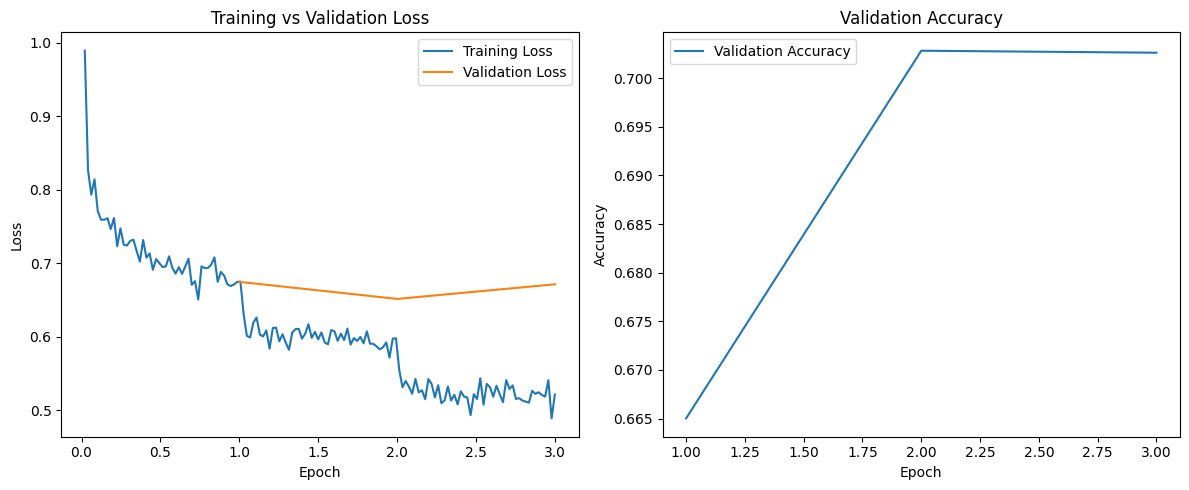

Generating predictions...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- Classification Report ---
              precision    recall  f1-score   support

    Negative     0.6823    0.7169    0.6992     11006
     Neutral     0.6215    0.5370    0.5762     13921
    Positive     0.7814    0.8558    0.8169     14034

    accuracy                         0.7026     38961
   macro avg     0.6951    0.7032    0.6974     38961
weighted avg     0.6963    0.7026    0.6976     38961



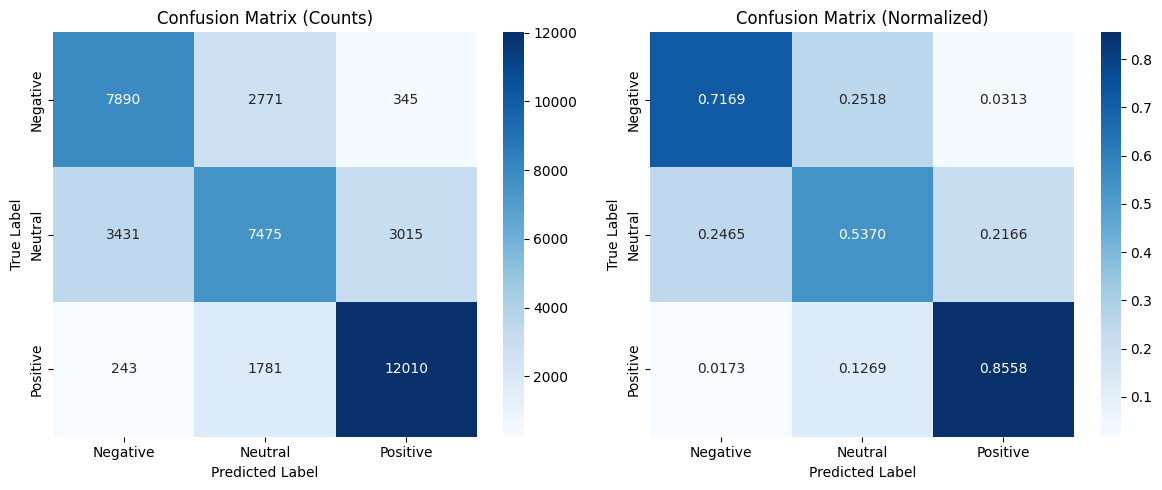

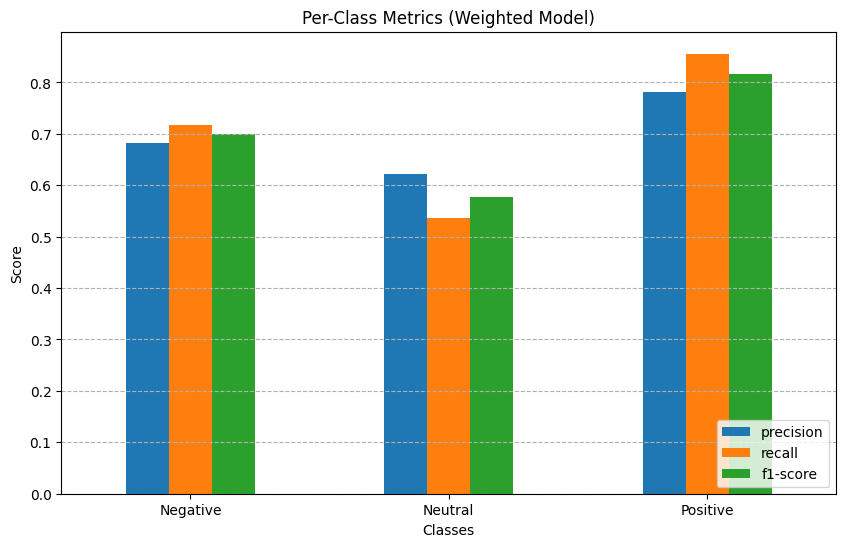


💾 Saving model to /kaggle/working/Final_Model_3Class_RobertaB_Composite1_194k...
📦 Zipping model for easy download...
✅ DONE! You can now download 'Final_Model_3Class_RobertaB_Composite1_194k.zip' from the 'Output' tab on the right.


In [5]:
# --- PART 5: EVALUATION & SAVING (KAGGLE VERSION) ---

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import shutil # For zipping the model

# ==========================
# EVALUATE • REPORT • PLOTS • SAVE
# ==========================
print("\n--- Final Evaluation on Test Set ---")

# 1. PLOT LOSS CURVES
# Access logs
log_history = trainer.state.log_history
train_logs = [log for log in log_history if ('loss' in log and 'eval_loss' not in log)]
eval_logs = [log for log in log_history if ('eval_loss' in log)]

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot([log.get('epoch', i) for i, log in enumerate(train_logs, 1)], [log['loss'] for log in train_logs], label='Training Loss')
plt.plot([log.get('epoch', i) for i, log in enumerate(eval_logs, 1)], [log['eval_loss'] for log in eval_logs], label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training vs Validation Loss'); plt.legend()


# Accuracy Plot
plt.subplot(1, 2, 2)
if len(eval_logs) > 0 and 'eval_accuracy' in eval_logs[0]:
    plt.plot([log.get('epoch', i) for i, log in enumerate(eval_logs, 1)], [log['eval_accuracy'] for log in eval_logs], label='Validation Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Validation Accuracy'); plt.legend()
plt.tight_layout(); plt.show()

# 2. PREDICTIONS (FIXED & SAFE)
print("Generating predictions...")
preds_output = trainer.predict(tokenized_datasets["test"])

# --- SAFETY CHECK START ---
if isinstance(preds_output.predictions, tuple):
    logits = preds_output.predictions[0]  # Extract logits if it's a tuple
else:
    logits = preds_output.predictions     # Use directly if it's an array
# --- SAFETY CHECK END ---

pred_labels = np.argmax(logits, axis=-1)
true_labels = np.array(tokenized_datasets["test"]["label"])

# 3. CLASSIFICATION REPORT (Updated to 4 decimal places)
print("\n--- Classification Report ---")
report_dict = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)

# digits=4 for detailed precision
print(classification_report(true_labels, pred_labels, target_names=class_names, digits=4))

# 4. CONFUSION MATRIX (Updated to 4 decimal places)
cm = confusion_matrix(true_labels, pred_labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 5))

# Counts (Integers)
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Counts)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Normalized (Floats with 4 decimals)
plt.subplot(1, 2, 2)
sns.heatmap(cm_norm, annot=True, fmt='.4f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Normalized)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')


plt.tight_layout()
plt.show()

# 5. PER-CLASS BAR CHART
report_df = pd.DataFrame(report_dict).transpose()
report_df_classes = report_df.loc[[cn for cn in class_names if cn in report_df.index]]
ax = report_df_classes[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title('Per-Class Metrics (Weighted Model)')
plt.xlabel('Classes'); plt.ylabel('Score')
plt.xticks(rotation=0); plt.grid(axis='y', linestyle='--'); plt.legend(loc='lower right')
plt.show()

# 6. SAVE (KAGGLE SPECIFIC)
# Kaggle saves to /kaggle/working/
FINAL_MODEL_DIR = "Final_Model_3Class_RobertaB_Composite1_194k" 
FINAL_MODEL_PATH = f"/kaggle/working/{FINAL_MODEL_DIR}"

print(f"\n💾 Saving model to {FINAL_MODEL_PATH}...")
trainer.save_model(FINAL_MODEL_PATH)

# --- ZIP FOR DOWNLOAD ---
# Kaggle makes it hard to download folders. We zip it so you can download 1 file.
print("📦 Zipping model for easy download...")
shutil.make_archive(f"/kaggle/working/{FINAL_MODEL_DIR}", 'zip', FINAL_MODEL_PATH)

print(f"✅ DONE! You can now download '{FINAL_MODEL_DIR}.zip' from the 'Output' tab on the right.")